In [ ]:
"""classical_models.ipynb
by: Archie Gertsman (arkadiy2@illinois.edu)
Project director: Richard Sowers
r-sowers@illinois.eduhttps://publish.illinois.edu/r-sowers/
Copyright 2019 University of Illinois Board of Trustees. All Rights Reserved. Licensed under the MIT license
"""

In [4]:
import sys
sys.path.append('../../Lib/')
import pandas as pd
import numpy as np
from feature_eng import split_trajectories
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [5]:
df = pd.read_pickle('../Data/block4_29_comp_feat_idfix.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '../Data/block4_29_comp_feat_idfix.pkl'

In [8]:
def reset_traj_and_split(df, traj_len):
    df.index = df.index.droplevel(1)
    return split_trajectories(df, traj_len)

In [9]:
def agg(df):
    df_agg = df[np.isin(df['type'], ['Car','Taxi'])] \
        .groupby(['id', 'traj']).agg({
            'xtrack_dist': 'std',
            'avg_surr_speed': ['mean','std'],
            'lon_acc': ['mean','std'],
            'lat_acc': ['mean','std'],
            'type': 'first'
        }) \
        .reset_index(drop=True)

    df_agg.columns = ['_'.join(col) for col in df_agg.columns]
    df_agg.rename(columns={'type_first':'type'}, inplace=True)
    g = df_agg.groupby('type')
    df_agg = g.apply(lambda group: group.sample(g.size().min())).reset_index(drop=True)
    X,y = df_agg.drop('type', axis=1), df_agg['type']
    return X,y

In [197]:
def train_and_accuracy(X, y, model):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)

    a = y_hat==y_test
    return len(a[a==True]) / len(y_test)

In [203]:
traj_lens = np.arange(1500, 5000+250, step=250)

k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True)
accs = np.zeros(k)

models = {
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'SVM': SVC(),
    'Log Regression': LogisticRegression()
}

df_acc = pd.DataFrame(index=pd.MultiIndex.from_product([models.keys(), ['mean','std']]), columns=traj_lens)

for traj_len in traj_lens:
    df2 = reset_traj_and_split(df.copy(), traj_len)
    X,y = agg(df2)
    for name, model in models.items():
        for i, (train_index, test_index) in enumerate(kf.split(X,y)):
            accs[i] = train_and_accuracy(X, y, model)

        df_acc.loc[(name, 'mean'), traj_len] = round(100*accs.mean(), 3)
        df_acc.loc[(name, 'std'), traj_len] = round(100*accs.std(), 3)

        print(name, 'complete.')
    print('trajectory length', traj_len, 'complete.')

df_acc

Random Forest complete.
AdaBoost complete.
SVM complete.
Log Regression complete.
trajectory length 4250 complete.
Random Forest complete.
AdaBoost complete.
SVM complete.
Log Regression complete.
trajectory length 4500 complete.
Random Forest complete.
AdaBoost complete.
SVM complete.
Log Regression complete.
trajectory length 4750 complete.
Random Forest complete.
AdaBoost complete.
SVM complete.
Log Regression complete.
trajectory length 5000 complete.


4250    4500    4750    5000
Random Forest  mean  63.603  69.265  68.167   71.75
               std    9.491  11.602  10.729  17.411
AdaBoost       mean  63.235  68.456  66.833   62.75
               std    6.423   9.872  10.719   5.294
SVM            mean  75.441  69.485   73.25  68.917
               std    8.265   5.502   8.789  10.474
Log Regression mean  77.059  69.338    76.5  69.333
               std   12.899  12.529  16.378  13.781

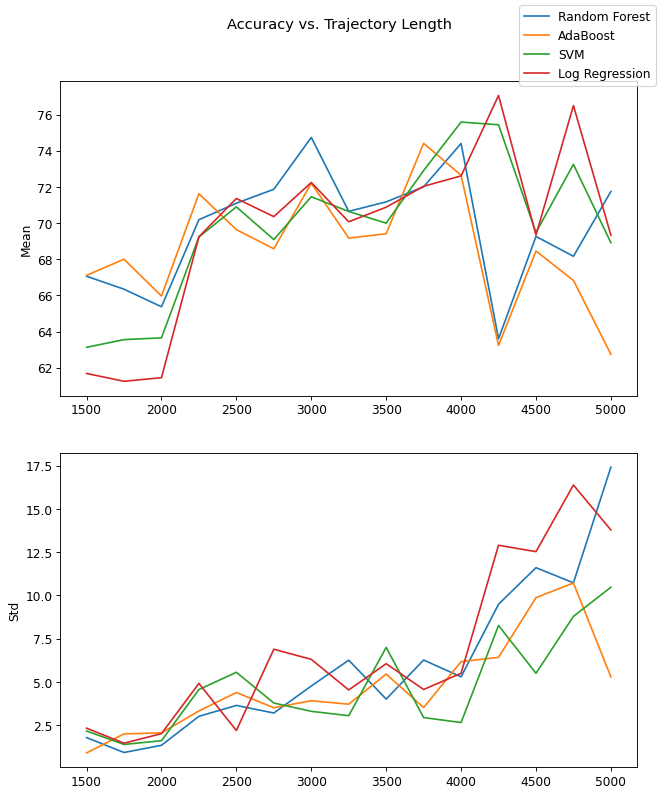

In [314]:
fig,ax = plt.subplots(2)

fig.set_size_inches(8,10)
fig.set_dpi(80)
fig.tight_layout(h_pad=3)
fig.suptitle('Accuracy vs. Trajectory Length')
plt.subplots_adjust(top=0.90)

ax_mean, ax_std = ax

ax_mean.set_ylabel('Mean')
ax_std.set_ylabel('Std')

for i,name in enumerate(models.keys()):
    ax_mean.plot(df_acc.columns, df_acc.loc[(name, 'mean')])
    ax_std.plot(df_acc.columns, df_acc.loc[(name, 'std')])

fig.legend(models.keys())
plt.show()